<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [43]:
# Set your student number
student_number = 400101967
Name = 'Ehsan'
Last_Name = 'Merrikhi'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [44]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

In [45]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

### Data Exploration
Let's take a look at the classes in our dataset.

In [46]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

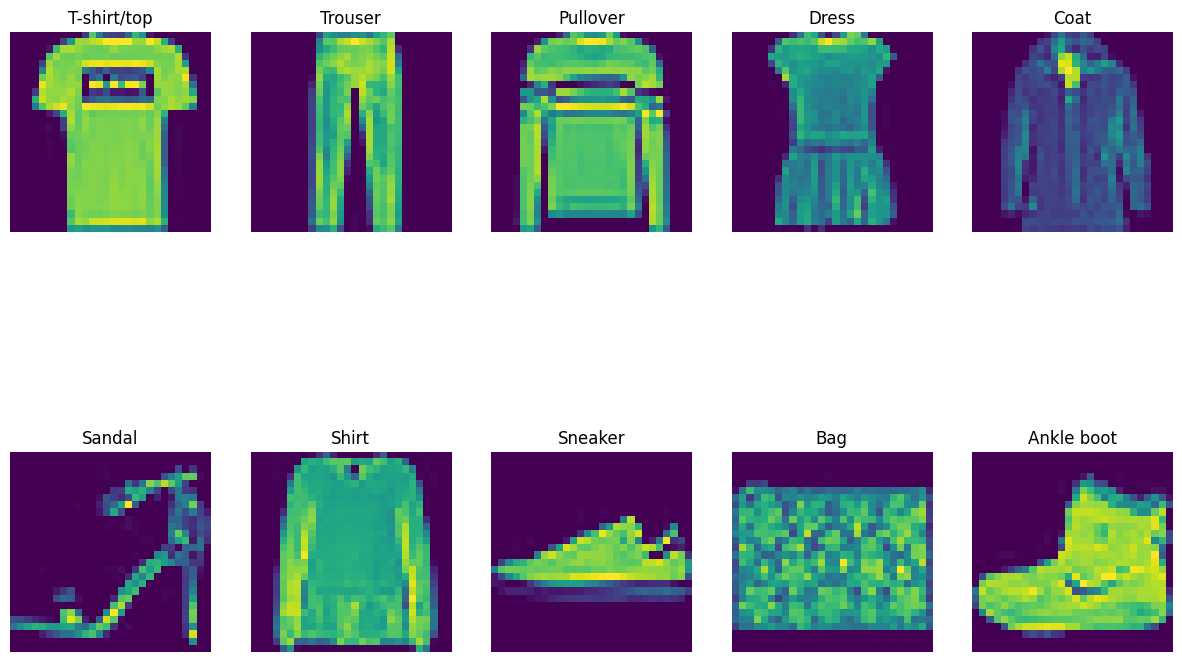

In [47]:
######################
num_classes = len(dataset.classes)

    # Dictionary to store the first image of each class
class_images = {i: None for i in range(num_classes)}

    # Iterate through the dataset and collect one image from each class
for img, label in dataset:
    if class_images[label] is None:
        class_images[label] = img
    if all(v is not None for v in class_images.values()):
        break

    # Plot the images
plt.figure(figsize=(15, 10))
for i in range(num_classes):
    plt.subplot(2, (num_classes + 1) // 2, i + 1)
    img = class_images[i]
    img = img.permute(1, 2, 0)  # Reorder dimensions for plotting
    plt.imshow(img)
    plt.title(dataset.classes[i])
    plt.axis('off')

plt.show()

######################

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [48]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [49]:
######################
#   YOUR CODE HERE   #
######################
val_frac =  20/100
rand_seed =  67

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [50]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [51]:
######################
#   YOUR CODE HERE   #
######################
batch_size = 25

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

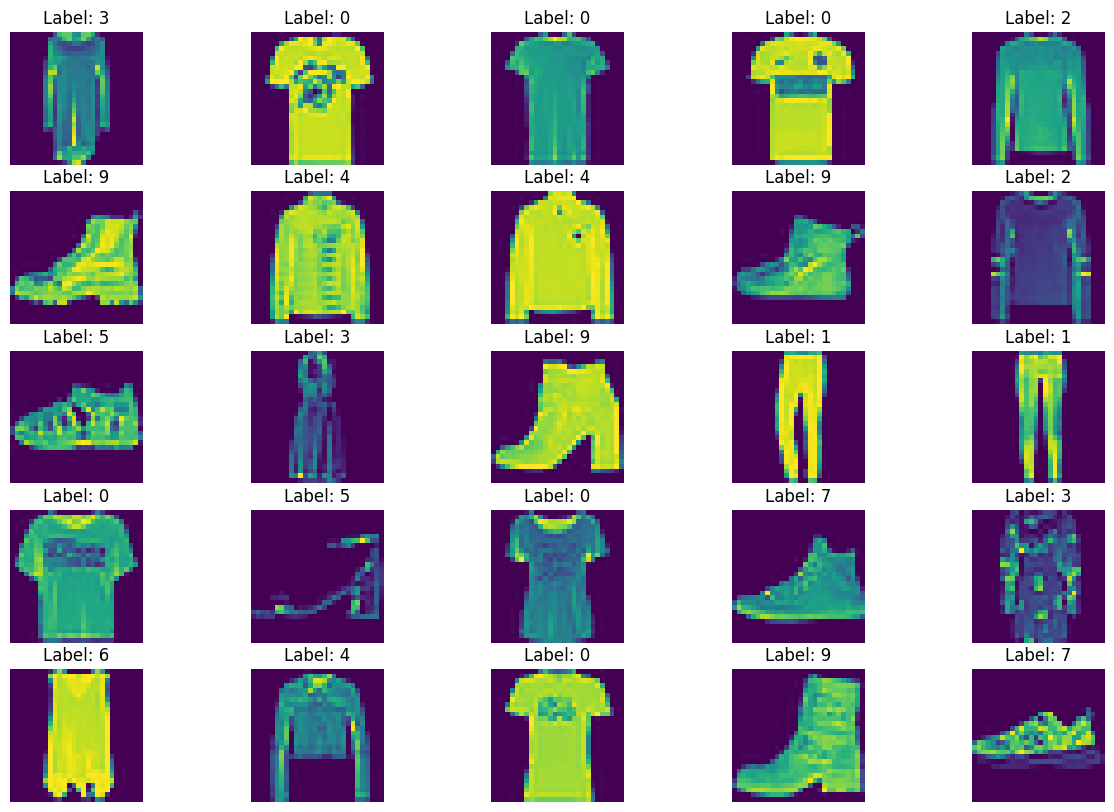

In [52]:
for batch in train_dl:
    imgs, labels = batch
    break

batch_size = imgs.size(0)

plt.figure(figsize=(15, 10))
for i in range(batch_size):
    plt.subplot(5, 5, i + 1)
    img = imgs[i]
    label = labels[i]
    if img.dim() == 3:
        img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.title(f'Label: {label.item()}')
    plt.axis('off')
plt.show()

### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [53]:
# Import required packages
# ----------------------------------------------
# Debugged up to here!!!
# ----------------------------------------------
# !pip install torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchinfo import summary
from tqdm.notebook import tqdm

In [54]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for FashionMNIST

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv_layer1(x)))
        x = self.pool(nn.functional.relu(self.conv_layer2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [55]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [56]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [25, 10]                  18,496
├─Conv2d: 1-1                            [25, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [25, 16, 14, 14]          --
├─Conv2d: 1-3                            [25, 32, 14, 14]          4,640
├─MaxPool2d: 1-4                         [25, 32, 7, 7]            --
├─Linear: 1-5                            [25, 128]                 200,832
├─Linear: 1-6                            [25, 10]                  1,290
Total params: 225,418
Trainable params: 225,418
Non-trainable params: 0
Total mult-adds (M): 30.93
Input size (MB): 0.08
Forward/backward pass size (MB): 3.79
Params size (MB): 0.83
Estimated Total Size (MB): 4.70

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [57]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    ######################
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = opt_fn(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.update()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dl.sampler)
        train_accuracy = correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if val_dl:
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in val_dl:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss /= len(val_dl.dataset) if val_dl else 1
            val_accuracy = correct / total

            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}/{n_epochs}.. "
                  f"Train loss: {train_loss:.3f}.. "
                  f"Train accuracy: {train_accuracy:.3f}.. "
                  f"Val loss: {val_loss:.3f}.. "
                  f"Val accuracy: {val_accuracy:.3f}")
        else:
            print(f"Epoch {epoch+1}/{n_epochs}.. "
                  f"Train loss: {train_loss:.3f}.. "
                  f"Train accuracy: {train_accuracy:.3f}")
    ######################

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [58]:
######################
class MyLoss:
    def __call__(self, outputs, targets):
      log_probs = F.log_softmax(outputs, dim=1)
      out = -log_probs[range(len(targets)), targets].mean()
      return out

class MyOpt:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def update(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()
######################
num_epochs = 20
loss_fn =  MyLoss()
opt_fn =  MyOpt
lr =  0.001

In [59]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch 1/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: 2.198.. Train accuracy: 0.353.. Val loss: 0.392.. Val accuracy: 0.568


Epoch 2/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: 1.247.. Train accuracy: 0.677.. Val loss: 0.158.. Val accuracy: 0.734


Epoch 3/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: 0.694.. Train accuracy: 0.753.. Val loss: 0.127.. Val accuracy: 0.768


Epoch 4/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: 0.609.. Train accuracy: 0.776.. Val loss: 0.117.. Val accuracy: 0.783


Epoch 5/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: 0.567.. Train accuracy: 0.792.. Val loss: 0.111.. Val accuracy: 0.798


Epoch 6/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: 0.536.. Train accuracy: 0.803.. Val loss: 0.105.. Val accuracy: 0.813


Epoch 7/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: 0.511.. Train accuracy: 0.813.. Val loss: 0.101.. Val accuracy: 0.818


Epoch 8/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: 0.492.. Train accuracy: 0.820.. Val loss: 0.096.. Val accuracy: 0.828


Epoch 9/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: 0.473.. Train accuracy: 0.828.. Val loss: 0.095.. Val accuracy: 0.828


Epoch 10/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: 0.457.. Train accuracy: 0.834.. Val loss: 0.091.. Val accuracy: 0.841


Epoch 11/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: 0.444.. Train accuracy: 0.840.. Val loss: 0.088.. Val accuracy: 0.844


Epoch 12/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 12/20.. Train loss: 0.431.. Train accuracy: 0.844.. Val loss: 0.086.. Val accuracy: 0.850


Epoch 13/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 13/20.. Train loss: 0.421.. Train accuracy: 0.850.. Val loss: 0.086.. Val accuracy: 0.850


Epoch 14/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 14/20.. Train loss: 0.412.. Train accuracy: 0.854.. Val loss: 0.082.. Val accuracy: 0.857


Epoch 15/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 15/20.. Train loss: 0.402.. Train accuracy: 0.856.. Val loss: 0.080.. Val accuracy: 0.861


Epoch 16/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 16/20.. Train loss: 0.394.. Train accuracy: 0.858.. Val loss: 0.080.. Val accuracy: 0.856


Epoch 17/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 17/20.. Train loss: 0.388.. Train accuracy: 0.862.. Val loss: 0.079.. Val accuracy: 0.856


Epoch 18/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 18/20.. Train loss: 0.382.. Train accuracy: 0.864.. Val loss: 0.078.. Val accuracy: 0.865


Epoch 19/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 19/20.. Train loss: 0.376.. Train accuracy: 0.866.. Val loss: 0.078.. Val accuracy: 0.864


Epoch 20/20:   0%|          | 0/1920 [00:00<?, ?it/s]

Epoch 20/20.. Train loss: 0.371.. Train accuracy: 0.867.. Val loss: 0.075.. Val accuracy: 0.868


### Plot loss and accuracy

In [62]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot training and validation accuracies."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, "-x", label="Training Accuracy", color='blue')
    plt.plot(val_accuracies, "-o", label="Validation Accuracy", color='red')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.legend(fontsize=12)
    plt.title("Accuracy vs. Number of Epochs", fontsize=16)
    plt.grid(True)
    plt.show()

def plot_losses(train_losses, val_losses):
    """Plot training and validation losses."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, "-x", label="Training Loss", color='blue')
    plt.plot(val_losses, "-o", label="Validation Loss", color='red')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.title("Loss vs. Number of Epochs", fontsize=16)
    plt.grid(True)
    plt.show()


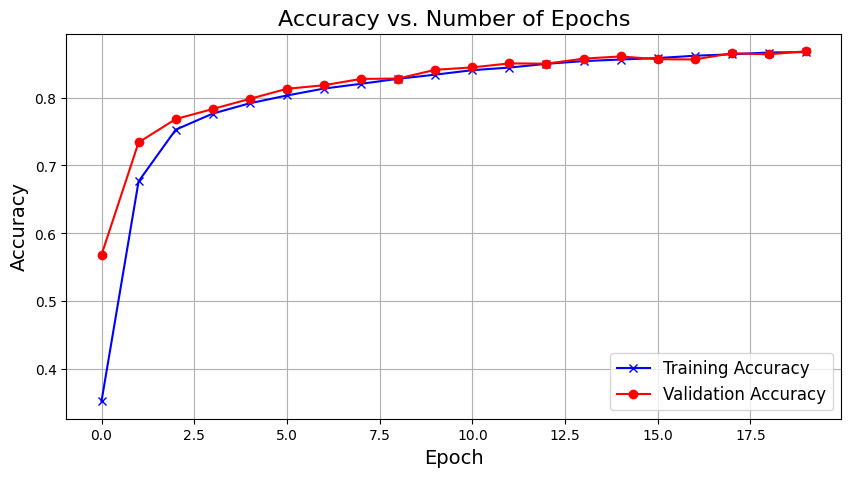

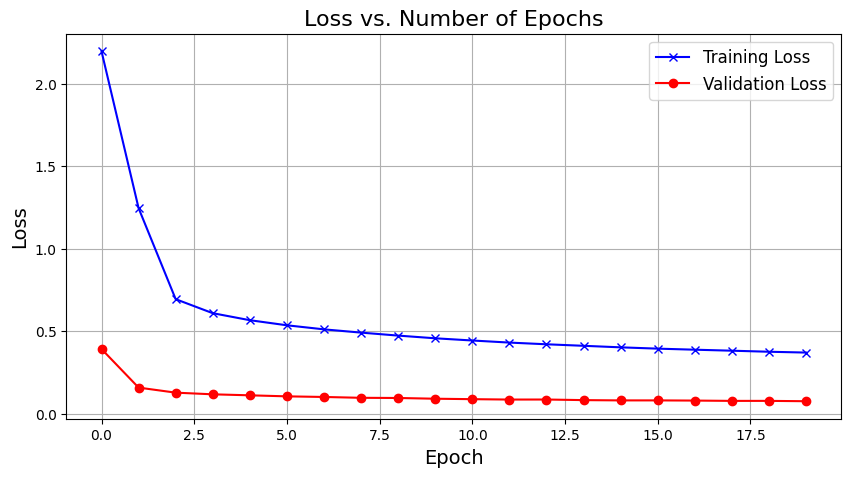

In [63]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [64]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [65]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 15 # Max number of training epochs
lr = 0.001 # Set the learning rate

In [66]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

Epoch 1/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 1/15.. Train loss: 0.366.. Train accuracy: 0.869


Epoch 2/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 2/15.. Train loss: 0.361.. Train accuracy: 0.871


Epoch 3/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 3/15.. Train loss: 0.355.. Train accuracy: 0.874


Epoch 4/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 4/15.. Train loss: 0.350.. Train accuracy: 0.876


Epoch 5/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 5/15.. Train loss: 0.345.. Train accuracy: 0.878


Epoch 6/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 6/15.. Train loss: 0.340.. Train accuracy: 0.880


Epoch 7/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 7/15.. Train loss: 0.336.. Train accuracy: 0.882


Epoch 8/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 8/15.. Train loss: 0.332.. Train accuracy: 0.883


Epoch 9/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 9/15.. Train loss: 0.328.. Train accuracy: 0.883


Epoch 10/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 10/15.. Train loss: 0.324.. Train accuracy: 0.886


Epoch 11/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 11/15.. Train loss: 0.320.. Train accuracy: 0.886


Epoch 12/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 12/15.. Train loss: 0.317.. Train accuracy: 0.887


Epoch 13/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 13/15.. Train loss: 0.313.. Train accuracy: 0.888


Epoch 14/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 14/15.. Train loss: 0.310.. Train accuracy: 0.890


Epoch 15/15:   0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 15/15.. Train loss: 0.307.. Train accuracy: 0.891


### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

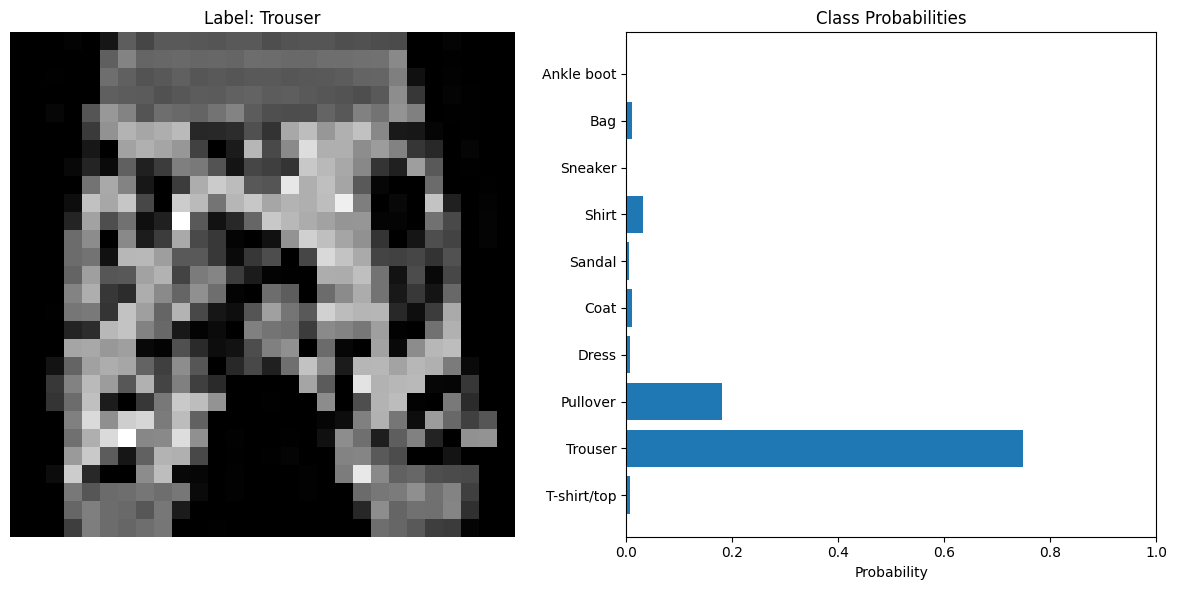

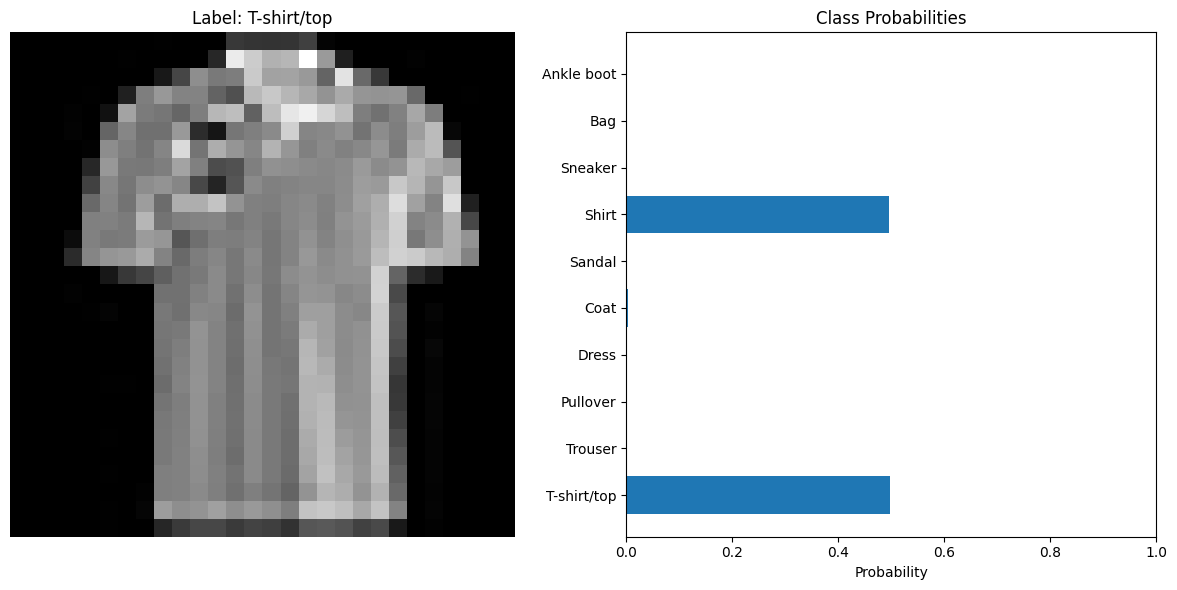

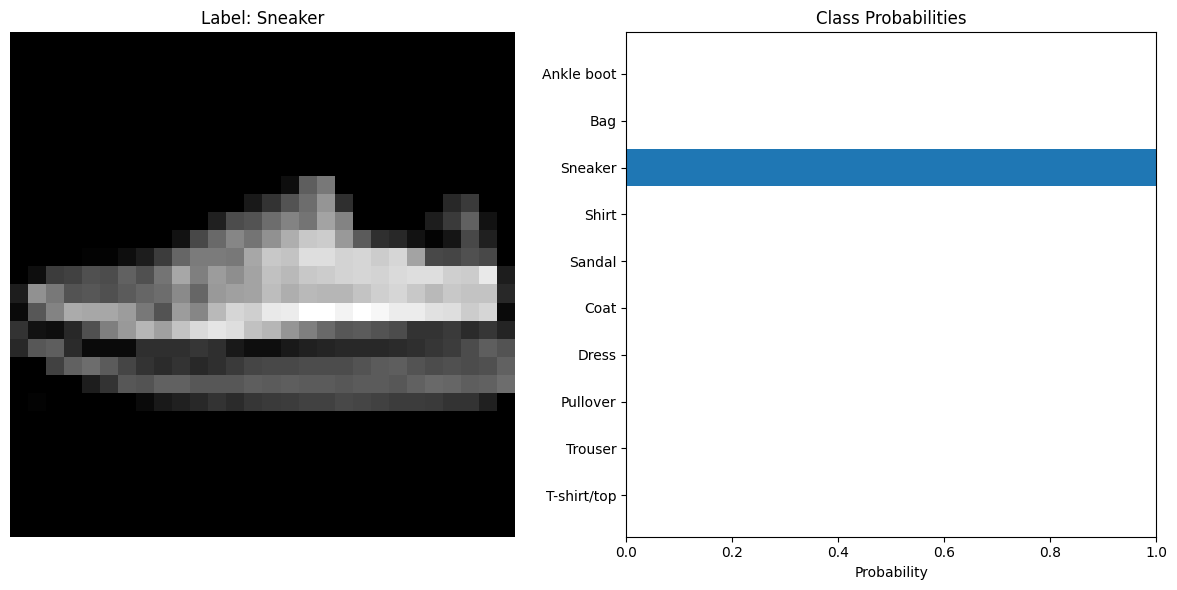

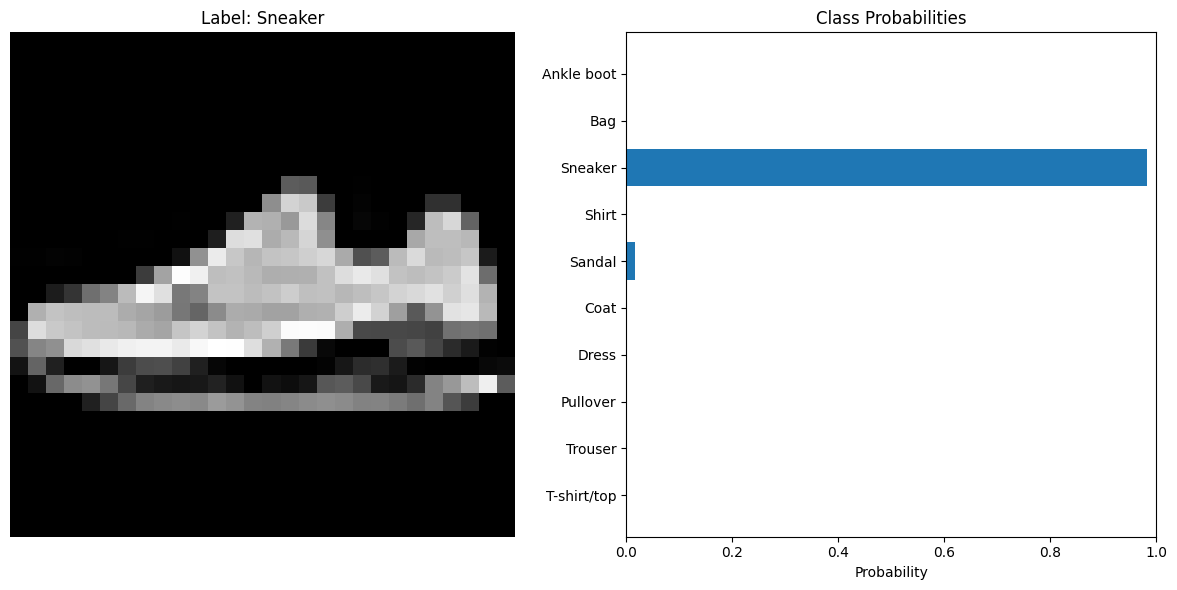

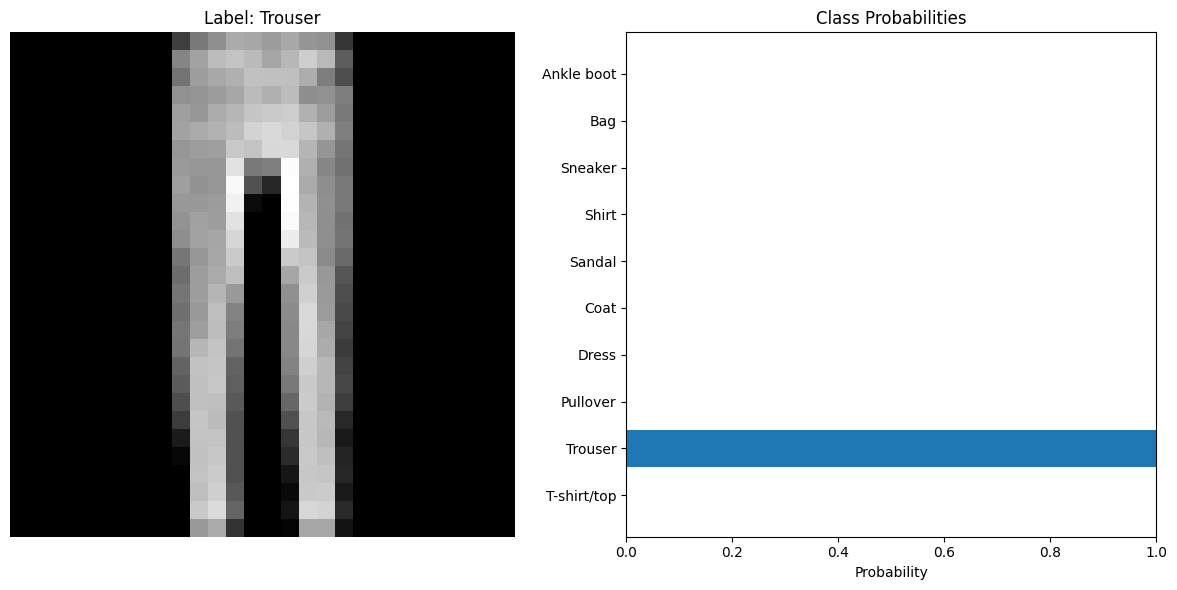

In [67]:
######################
def view_prediction(image, label, probabilities, class_names):
    plt.figure(figsize=(12, 6))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {class_names[label]}")
    plt.axis('off')

    # Plot the probabilities
    plt.subplot(1, 2, 2)
    plt.barh(class_names, probabilities)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')
    plt.xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Evaluate the model on a few samples
model.eval()
sample_indices = np.random.choice(indices, size=5, replace=False)

for idx in sample_indices:
    image, label = dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        probabilities = torch.nn.functional.softmax(output, dim=1).squeeze().numpy()

    view_prediction(image.squeeze().numpy(), label, probabilities, dataset.classes)
######################

### Save the model

In [68]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [69]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [70]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    ######################
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_dl:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total if total > 0 else 0
    return test_accuracy
    ######################

In [71]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 0.8833
